In [1]:
import libspn as spn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

# Params

### Structure

In [25]:
# Type of input distributions for dense generator
input_dist = spn.DenseSPNGeneratorLayerNodes.InputDist.MIXTURE
learning_rate = 1e-2

num_decomps=1
num_subsets=5
num_mixtures=2

# Number of input mixtures for dense generator
num_input_mixtures = 4
node_type = spn.DenseSPNGeneratorLayerNodes.NodeType.LAYER
num_batches = 512

balanced = False  #True


learning_type = spn.LearningType.DISCRIMINATIVE
#learning_type = spn.LearningType.GENERATIVE
additive_smoothing = 100
min_additive_smoothing = 1
smoothing_decay = 0.2
learning_rate = 0.1
initial_accum_value = None  # 20 was used for corridor

# Weight initialization
weight_init_value = spn.ValueType.RANDOM_UNIFORM(0, 1)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

# Add random values before max
add_random = None
use_unweighted = False#True



### Learning

In [3]:
# Additive smoothing during learning
additive_smoothing=100
min_additive_smoothing=1
smoothing_decay=0.2

# Weight initialization
# weight_init_value = 1
# weight_init_value = spn.ValueType.RANDOM_UNIFORM(10, 11)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

# Training Set

In [4]:
datasets = tf.contrib.learn.datasets.mnist.read_data_sets("/home/jos/datasets/mnist")

Extracting /home/jos/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/jos/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/jos/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/jos/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [5]:
def show_mnist(img):
    img=np.reshape(img, (14,14))
    plt.imshow(img, interpolation='none')
    plt.show()

### Process data

In [6]:
def process_set(data):
#     threshold = 20
    images = np.reshape(data, (-1, 28,28))
    resized=[]
    for i in range(images.shape[0]):
        resized.append((scp.misc.imresize(images[i, :, :], 0.5).ravel()))
    images=np.vstack((resized - np.mean(resized)) / np.std(resized))
    return images

In [7]:
train_images = process_set(datasets.train.images)
test_images = process_set(datasets.test.images)
train_labels = datasets.train.labels
test_labels = datasets.test.labels
validation_labels = datasets.validation.labels

/home/jos/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


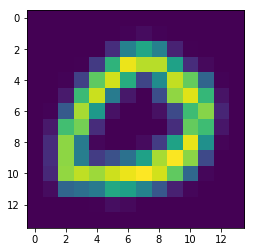

In [8]:
show_mnist(train_images[19])

In [9]:
train_images_0 = train_images[train_labels==0]
train_images_1 = train_images[train_labels==1]
test_images_0 = test_images[test_labels==0]
test_images_1 = test_images[test_labels==1]

(5444, 196)


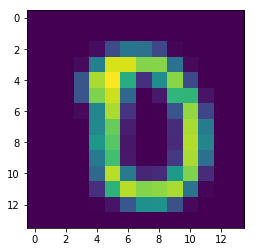

(6179, 196)


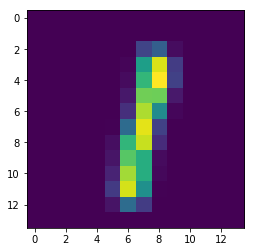

(980, 196)


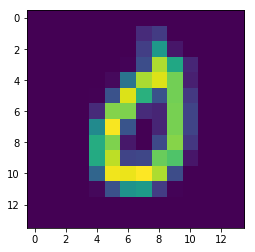

(1135, 196)


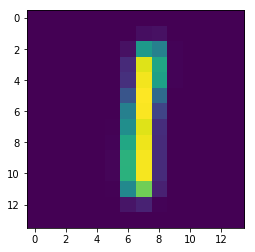

In [10]:
print(train_images_0.shape)
show_mnist(train_images_0[334])
print(train_images_1.shape)
show_mnist(train_images_1[22])
print(test_images_0.shape)
show_mnist(test_images_0[334])
print(test_images_1.shape)
show_mnist(test_images_1[22])

# Generate SPN structure

In [18]:
gauss_quantiles = spn.GaussianQuantile(num_vars=196, num_components=2)
gauss_quantiles.learn_from_data(train_images, use_prior=True)

dense_gen = spn.DenseSPNGeneratorLayerNodes(num_decomps=num_decomps,
                                        num_subsets=num_subsets,
                                        num_mixtures=num_mixtures,
                                        input_dist=input_dist,
                                        balanced=balanced,
                                        num_input_mixtures=num_input_mixtures,
                                        node_type=node_type)


# learning = spn.GDLearning(root, log=True, value_inference_type=value_inference_type,
#                       learning_rate=learning_rate,
#                       learning_type=learning_type,
#                       additive_smoothing=additive_smoothing_var,
#                       add_random=add_random,
#                       initial_accum_value=initial_accum_value,
#                       use_unweighted=use_unweighted)

root0 = dense_gen.generate(gauss_quantiles)
root1 = dense_gen.generate(gauss_quantiles)
root = spn.Sum(root0, root1)
spn.generate_weights(root, init_value=weight_init_value)
latent = root.generate_ivs()
print(root.get_num_nodes())

32


# Add Learning Ops

In [26]:
additive_smoothing_var = tf.Variable(additive_smoothing, dtype=spn.conf.dtype)
# learning = spn.EMLearning(root, log=True, value_inference_type = value_inference_type,
#                           additive_smoothing=additive_smoothing_var)

learning = spn.GDLearning(root, log=True, value_inference_type=value_inference_type,
                      learning_rate=learning_rate,
                      learning_type=learning_type,
                      additive_smoothing=additive_smoothing_var,
                      add_random=add_random,
                      initial_accum_value=initial_accum_value,
                      use_unweighted=use_unweighted)
init_weights = spn.initialize_weights(root)
reset_accumulators = learning.reset_accumulators()
accumulate_updates = learning.accumulate_updates()
update_spn = learning.update_spn()
train_likelihood=learning.value.values[root]
avg_train_likelihood = tf.reduce_mean(train_likelihood)

In [14]:
from tensorflow.python import debug as tfdebug

# Run Training

In [14]:
sess=None
from tqdm import tqdm_notebook

In [ ]:
from sklearn.utils import shuffle

In [16]:
debug = False
writer = tf.summary.FileWriter('./tfdebug') if debug else None

In [27]:
train_set = np.concatenate([train_images_0, train_images_1], 0)
train_labels = np.concatenate([np.ones((train_images_0.shape[0]))*0, 
                               np.ones((train_images_1.shape[0]))*1])
train_labels=np.reshape(train_labels, (-1, 1))

if sess is not None:
    sess.close()

sess = tf.Session()
if writer:
    writer.add_graph(sess.graph)
# if debug:
#     sess = tf_debug.TensorBoardDebugWrapperSession(sess, 'localhost:6064')
sess.run(init_weights)
sess.run(reset_accumulators)

num_batches=128
batch_size = train_set.shape[0] // num_batches
prev_likelihood = 100
likelihood = 0
epoch = 0
while abs(prev_likelihood - likelihood)>0.1:
    prev_likelihood=likelihood
    likelihoods = []
    pbar = tqdm_notebook(range(num_batches))
    train_set, train_labels = shuffle(train_set, train_labels)
    for batch in pbar:
        start = (batch)*batch_size
        stop = (batch+1)*batch_size
#         print("EPOCH", epoch, "BATCH", batch, "SAMPLES", start, stop)
        # Adjust smoothing
        ads=max(np.exp(-epoch*smoothing_decay)*additive_smoothing, min_additive_smoothing)
        sess.run(additive_smoothing_var.assign(ads))
#         print("Smoothing: ", sess.run(additive_smoothing_var)) 
        # Run accumulate_updates
        train_likelihoods_arr, avg_train_likelihood_val, _, = \
                sess.run([train_likelihood, avg_train_likelihood, accumulate_updates],
                        feed_dict={gauss_quantiles: train_set[start:stop],
                                   latent: train_labels[start:stop]})
        # Print avg likelihood of this batch data on previous batch weights
#         print("Avg likelihood (this batch data on previous weights): %s" % (avg_train_likelihood_val))
        likelihoods.append(avg_train_likelihood_val)
        pbar.set_description("lh {}".format(avg_train_likelihood_val if not np.isnan(avg_train_likelihood_val) else "NaN"))
        # Update weights
        sess.run(update_spn)
    likelihood = sum(likelihoods) / len(likelihoods)
    print("Avg likelihood: %s" % (likelihood))
    epoch+=1
    sess.run(reset_accumulators)



Avg likelihood: -160.3018330335617



Avg likelihood: -160.20648992061615


# Generate Testing Ops

In [18]:
mpe_state_gen = spn.MPEState(log=True, value_inference_type=spn.InferenceType.MPE)

In [19]:
mpe_gauss_quantiles, mpe_latent = mpe_state_gen.get_state(root, gauss_quantiles, latent)

# Run Testing

### MPE of the whole network

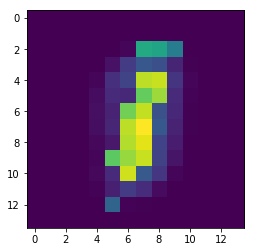

[[1]]


In [20]:
no_evidence = np.zeros((1, 14 * 14)).astype(np.bool) 
mpe_gauss_val, mpe_latent_val = sess.run([mpe_gauss_quantiles, mpe_latent], feed_dict={
    gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[-1]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### MPE for 0

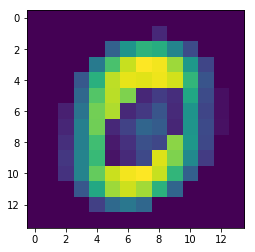

[[0]]


In [21]:
mpe_gauss_val, mpe_latent_val = sess.run(
    [mpe_gauss_quantiles, mpe_latent], feed_dict={gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[0]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### MPE for 1

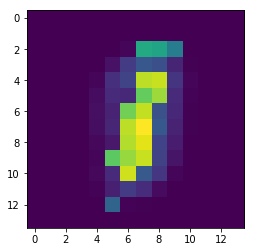

[[1]]


In [22]:
mpe_gauss_val, mpe_latent_val = sess.run(
    [mpe_gauss_quantiles, mpe_latent], feed_dict={gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[1]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### Classification of Training Data

In [27]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={
    gauss_quantiles: train_set, latent: np.ones((train_set.shape[0], 1))*-1})
result=(mpe_latent_val==train_labels)
np.sum(result) / train_labels.size

0.9967306203217758

### Classification of Test Data

In [28]:
test_set = np.concatenate([test_images_0, test_images_1], 0)
test_labels = np.concatenate([np.ones((test_images_0.shape[0]))*0, 
                               np.ones((test_images_1.shape[0]))*1])
test_labels=np.reshape(test_labels, (-1, 1))

In [29]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={gauss_quantiles: test_set, 
                                                   latent: np.ones((test_set.shape[0], 1))*-1})
result=(mpe_latent_val==test_labels)
np.sum(result) / test_labels.size

0.5366430260047281